In [1]:
import mibian
import pandas as pd
import numpy as np
import random

In [2]:
class Strategy(object):
    
    interestRate = 0.5
    
    def __init__(self, underPrice, Strike1, Strike2, Strike3, Strike4, days, impVol1, impVol2, impVol3, impVol4):
        self.underPrice = underPrice
        self.Strike1 = Strike1
        self.Strike2 = Strike2
        self.Strike3 = Strike3
        self.Strike4 = Strike4
        self.days = days
        self.impVol1 = impVol1
        self.impVol2 = impVol2
        self.impVol3 = impVol3
        self.impVol4 = impVol4

In [3]:
class volStrategy(Strategy):
    
    def __init__(self, stype):
        self.ftype = stype

    def straddle(underPrice, Strike, days, impVol):
        leg = mibian.BS([underPrice, Strike, Strategy.interestRate, days], volatility = impVol)
        return leg.callPrice + leg.putPrice

    def strangle(underPrice, Strike1, Strike2, days, impVol1, impVol2):
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        if Strike1 >= Strike2:
            return leg1.callPrice + leg2.putPrice
        else:
            return leg1.putPrice + leg2.callPrice

In [4]:
class statStrategy(Strategy):
    
    def __init__(self, stype):
        self.ftype = stype
    
    def leverage():
        return self - (Strategy.Strike1 - Strategy.Strike2) 
                
        

In [5]:
class spread(statStrategy):
    
    def __init__(self, ftype):
        self.ftype = ftype
        
    def callSpread(underPrice, Strike1, Strike2, days, impVol1, impVol2):
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        return abs(leg1.callPrice - leg2.callPrice)
    
    def putSpread(underPrice, Strike1, Strike2, days, impVol1, impVol2):
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        return abs(leg1.putPrice - leg2.putPrice)

In [6]:
class fly(statStrategy):

    def __init__(self, ftype):
        self.ftype = ftype       
            
    def atmFly(underPrice, Strike1, Strike2, Strike3, days, impVol1, impVol2, impVol3):
        
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        leg3 = mibian.BS([underPrice, Strike3, Strategy.interestRate, days], volatility = impVol3)
        
        if Strike1 >= Strike3:
            return leg1.callPrice + leg3.putPrice - (leg2.callPrice + leg2.putPrice)
        else:
            return leg1.putPrice + leg3.callPrice - (leg2.callPrice + leg2.putPrice)
        
    def callFly(underPrice, Strike1, Strike2, Strike3, days, impVol1, impVol2, impVol3):
    
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        leg3 = mibian.BS([underPrice, Strike3, Strategy.interestRate, days], volatility = impVol3)
        
        return leg1.callPrice + leg3.callPrice - 2*leg2.callPrice
    
    def putFly(underPrice, Strike1, Strike2, Strike3, days, impVol1, impVol2, impVol3):
    
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        leg3 = mibian.BS([underPrice, Strike3, Strategy.interestRate, days], volatility = impVol3)
        
        return leg1.putPrice + leg3.putPrice - 2*leg2.putPrice       
    

In [7]:
class condor(statStrategy):
    
    def __init__(self, ftype):
        self.ftype = ftype       
            
    def atmCondor(underPrice, Strike1, Strike2, Strike3, Strike4, 
             days, impVol1, impVol2, impVol3, impVol4):
        
        return volStrategy.strangle(underPrice, Strike1, Strike4, days, impVol1,
                                    impVol4) - volStrategy.strangle(underPrice, Strike2, Strike3, 
                                                                    days, impVol2, impVol3) 
        
    def callCondor(underPrice, Strike1, Strike2, Strike3, Strike4, 
                   days, impVol1, impVol2, impVol3, impVol4):
    
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        leg3 = mibian.BS([underPrice, Strike3, Strategy.interestRate, days], volatility = impVol3)
        leg4 = mibian.BS([underPrice, Strike4, Strategy.interestRate, days], volatility = impVol4)
        
        return leg1.callPrice + leg3.callPrice - leg2.callPrice - leg4.callPrice
    
    def putCondor(underPrice, Strike1, Strike2, Strike3, Strike4, 
                  days, impVol1, impVol2, impVol3, impVol4):
    
        leg1 = mibian.BS([underPrice, Strike1, Strategy.interestRate, days], volatility = impVol1)
        leg2 = mibian.BS([underPrice, Strike2, Strategy.interestRate, days], volatility = impVol2)
        leg3 = mibian.BS([underPrice, Strike3, Strategy.interestRate, days], volatility = impVol3)
        leg4 = mibian.BS([underPrice, Strike4, Strategy.interestRate, days], volatility = impVol4)
        
        return leg1.putPrice + leg3.putPrice - leg2.putPrice - leg4.putPrice

In [8]:
import pandas as pd
import numpy as np
import random

#monte carlo price simulation function
def monte_carlo_price_sim(price, ndays, nreps, plong, pshort, maglong, magshort):
    
    #initial transformations and base matrix creation
    maglong_cents = price/100*maglong
    magshort_cents = -price/100*magshort
    nmatrix = (ndays, nreps)
    simarray = np.ones(nmatrix)
        
    #simulation of price changes
    for i in range(ndays):
        for n in range(nreps):
            simarray[i, n] = random.random()
            if simarray[i, n] >= plong:
                simarray[i, n] = random.gauss(maglong_cents, 0.8)
            elif simarray[i, n] <= pshort:
                simarray[i, n] = random.gauss(magshort_cents, 0.8) 
            else:
                simarray[i, n] = 0
    
    #setting initial price and summing over the progression of days    
    simarray[0] = price
    
    for i in range(nreps):
        simarray[:,i] = np.cumsum(simarray[:,i])
        
    # transformation into a pandas dataframe and generation of labels
    colnames = []
    rownames = []
    
    for i in range(nreps):
        colnames.append("rep" + str(i+1))
    for i in range(ndays):
        rownames.append("day" + str(i+1))
    
    simprices = pd.DataFrame(simarray, columns=colnames, index=rownames)
    #output    
    return simprices

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def straddle(underPrice, Strike, days, impVol):
    leg = mibian.BS([underPrice, Strike, Strategy.interestRate, days], volatility = impVol)
    return leg.callPrice + leg.putPrice

price = 356
ndays = 31
nreps = 100
plong = 0.49
pshort = 0.49
maglong = 1.0
magshort = 1.0

x = monte_carlo_price_sim(price, ndays, nreps, plong, pshort, maglong, magshort)

z = (ndays, nreps)
w = np.ones(z)
y = np.ones(z)
           
for i in range(ndays):
    y[i] = x.ix[i]
    for n in range(nreps):
        w[i, n] = straddle(y[i, n], 355, (ndays-i), 16.00)

w = pd.DataFrame(w)

In [11]:
w.ix[30].mean()

16.300637311909586

(array([ 51.,  11.,  16.,   5.,   4.,   5.,   5.,   1.,   1.,   1.]),
 array([ 12.76502217,  13.07587378,  13.3867254 ,  13.69757701,
         14.00842863,  14.31928024,  14.63013186,  14.94098347,
         15.25183509,  15.5626867 ,  15.87353832]),
 <a list of 10 Patch objects>)

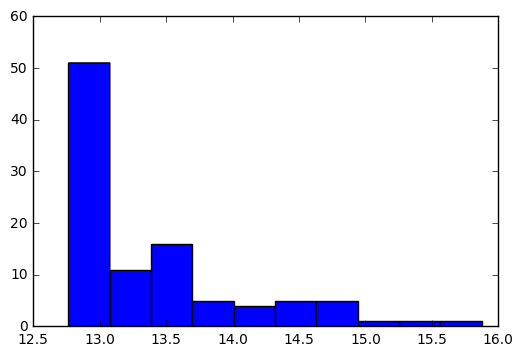

In [12]:
plt.hist(w.ix[2])

In [13]:
wF = np.ones(z)
           
for i in range(ndays):
    y[i] = x.ix[i]
    for n in range(nreps):
        wF[i, n] = spread.putSpread(y[i, n], 350, 340, (ndays-i), 16.9, 17.8)

wF = pd.DataFrame(wF)

In [14]:
wF.ix[ndays-1].mean()

2.0529069993994393

(array([ 70.,   2.,   3.,   3.,   2.,   2.,   3.,   2.,   1.,  12.]),
 array([  1.13183643e-61,   9.99986301e-01,   1.99997260e+00,
          2.99995890e+00,   3.99994521e+00,   4.99993151e+00,
          5.99991781e+00,   6.99990411e+00,   7.99989041e+00,
          8.99987671e+00,   9.99986301e+00]),
 <a list of 10 Patch objects>)

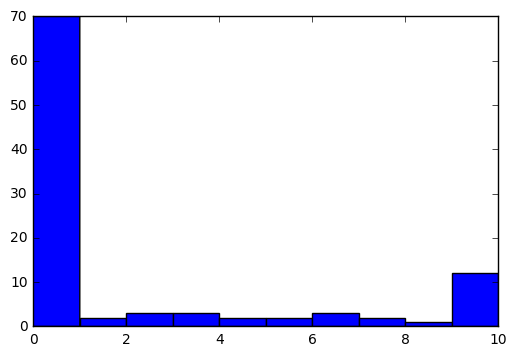

In [15]:
plt.hist(wF.ix[30])

In [16]:
wwF = np.ones(z)
for i in range(ndays):
    y[i] = x.ix[i]
    for n in range(nreps):
        wwF[i, n] = fly.putFly(y[i, n], 350, 340, 330, (ndays-i), 16.8, 17.5, 18.5)

wwF = pd.DataFrame(wwF)

In [17]:
wwF.ix[ndays-1].mean()

1.0598488705593931